In [1]:
import pandas as pd
import requests
import pygwalker as pg
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
def get_southaus_data(port):
    fission_url = f"http://localhost:{port}/search-south-crimegov"
    response = requests.get(fission_url,verify=False)
    return response.json()

In [3]:
def process_southaus():
    south_aus = pd.DataFrame(get_southaus_data(9030))
    south_aus = south_aus.drop('@timestamp', axis=1)
    south_aus['Sum of Offence count' ] = south_aus['Sum of Offence count' ].astype(str)
    south_aus['Sum of Offence count' ] = south_aus['Sum of Offence count' ].str.replace(',', '')
    south_aus['Sum of Offence count' ] = south_aus['Sum of Offence count' ].astype(int)
    south_aus['Reported Date per month'] = pd.to_datetime(south_aus['Reported Date per month'])
    # Extract month and year
    south_aus['Month'] = south_aus['Reported Date per month'].dt.month
    south_aus['Year'] = south_aus['Reported Date per month'].dt.year
    # Create the new DataFrame with the desired columns
    new_df = south_aus[['Month', 'Sum of Offence count', 'Year']]
    # Rename columns
    new_df.columns = ['Month', 'Count', 'Year']
    return new_df

In [4]:
def pgwalk_southaus():
    new_df = process_southaus()
    vis_spec = r"""{"config":[{"config":{"defaultAggregated":false,"geoms":["area"],"coordSystem":"generic","limit":-1,"timezoneDisplayOffset":0,"folds":["Count"]},"encodings":{"dimensions":[{"fid":"Count","name":"Count","basename":"Count","analyticType":"dimension","semanticType":"quantitative","aggName":"sum","offset":0},{"fid":"gw_mea_key_fid","name":"Measure names","analyticType":"dimension","semanticType":"nominal"}],"measures":[{"fid":"Month","name":"Month","basename":"Month","semanticType":"quantitative","analyticType":"measure","offset":0},{"fid":"Year","name":"Year","basename":"Year","semanticType":"nominal","analyticType":"measure","offset":0},{"fid":"gw_count_fid","name":"Row count","analyticType":"measure","semanticType":"quantitative","aggName":"sum","computed":true,"expression":{"op":"one","params":[],"as":"gw_count_fid"}},{"fid":"gw_mea_val_fid","name":"Measure values","analyticType":"measure","semanticType":"quantitative","aggName":"sum"}],"rows":[{"fid":"Count","name":"Count","basename":"Count","analyticType":"dimension","semanticType":"quantitative","aggName":"sum","offset":0}],"columns":[{"fid":"Month","name":"Month","basename":"Month","semanticType":"quantitative","analyticType":"dimension","offset":0}],"color":[{"fid":"Year","name":"Year","basename":"Year","semanticType":"nominal","analyticType":"measure","offset":0}],"opacity":[{"fid":"Year","name":"Year","basename":"Year","semanticType":"nominal","analyticType":"measure","offset":0}],"size":[],"shape":[],"radius":[],"theta":[],"longitude":[],"latitude":[],"geoId":[],"details":[],"filters":[{"fid":"Year","name":"Year","basename":"Year","semanticType":"nominal","analyticType":"measure","offset":0,"rule":{"type":"not in","value":[2021,2023]}}],"text":[]},"layout":{"showActions":true,"showTableSummary":false,"stack":"none","interactiveScale":false,"zeroScale":true,"size":{"mode":"fixed","width":462,"height":440},"format":{},"geoKey":"name","resolve":{"x":false,"y":false,"color":true,"opacity":true,"shape":false,"size":false},"scaleIncludeUnmatchedChoropleth":false,"showAllGeoshapeInChoropleth":false,"colorPalette":"spectral","useSvg":false,"scale":{"opacity":{},"size":{}}},"visId":"gw_2u97","name":"Chart 1"}],"chart_map":{},"workflow_list":[{"workflow":[{"type":"filter","filters":[{"fid":"Year","rule":{"type":"not in","value":[2021,2023]}}]},{"type":"view","query":[{"op":"raw","fields":["Month","Count","Year","Year"]}]}]}],"version":"0.4.8.4"}"""
    pg.walk(new_df, spec=vis_spec)

In [32]:
pgwalk_southaus()

Box(children=(HTML(value='<div id="ifr-pyg-000618e1660ea897vKCmoMzT8kqnb5Rd" style="height: auto">\n    <head>…

In [22]:
def get_vicpop_data(port):
    fission_url = f"http://localhost:{port}/search-vic-population"
    response = requests.get(fission_url,verify=False)
    return response.json()

In [23]:
def get_subcrimecount_data(port):
    fission_url = f"http://localhost:{port}/search-vic-crime-by-offence-count"
    response = requests.get(fission_url,verify=False)
    return response.json()

In [24]:
def process_vic_pop():
    population_data = pd.DataFrame(get_vicpop_data(9030))
    population_cols = [col for col in population_data.columns if 'tpop_' in col and int(col.split('_')[1]) in range(2019, 2024)]
    population_sums = []
    for col in population_cols:
        year = int(col.split('_')[1])
        pop_sum = population_data[col].sum()
        population_sums.append((year, pop_sum))
    population_sums.sort(key=lambda x: x[0])
    return population_sums

In [25]:
def process_vic_subcrime():
    crime_count = pd.DataFrame(get_subcrimecount_data(9030))
    crime_count['Sum of Offence Count' ] = crime_count['Sum of Offence Count' ].astype(str)
    crime_count['Sum of Offence Count' ] = crime_count['Sum of Offence Count' ].str.replace(',', '')
    crime_count['Sum of Offence Count' ] = crime_count['Sum of Offence Count' ].astype(int)
    return crime_count

In [26]:
def combine_vic_pop_crime():
    population_sums = process_vic_pop()    
    crime_count = process_vic_subcrime()
    population_df = pd.DataFrame(population_sums, columns=['year', 'population'])
    merged_df = pd.merge(crime_count, population_df, left_on='filters', right_on='year', how='left')
    merged_df = merged_df.drop(['filters'], axis=1)
    return merged_df

In [27]:
def build_train_pop_crime():
    merged_df = combine_vic_pop_crime()
    merged_df = merged_df.drop(columns=['Offence Division: Descending'])
    # Group by year and population, then sum the offence counts
    result = merged_df.groupby(['year', 'population']).sum().reset_index()
    result = result.drop(columns=['year'])
    X = result[['Sum of Offence Count']]
    y = result['population']
    return X, y

In [28]:
def data_pred():
    X,y = build_train_pop_crime()
    new_df = process_southaus()
    degree = 2
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)
    yearly_crime_counts = new_df.groupby('Year').agg({'Count': 'sum'}).reset_index()
    yearly_crime_counts.rename(columns={'Count': 'Sum of Crime Count'}, inplace=True)
    X_yearly = yearly_crime_counts[['Sum of Crime Count']]
    yearly_crime_counts['Predicted Population'] = model.predict(X_yearly).astype(int)
    
    # Creating a Random Forest regression model
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    model_rf.fit(X, y)
    # Predicting population based on Sum of Crime Count
    predicted_population_rf = model_rf.predict(X_yearly)
    predicted_population_rf = [max(0, p) for p in predicted_population_rf]  # Clip negative values to 0

    # Add the predicted population to the yearly_crime_counts DataFrame
    yearly_crime_counts['Predicted Population (Random Forest)'] = predicted_population_rf
    yearly_crime_counts['Predicted Population (Random Forest)'] = yearly_crime_counts['Predicted Population (Random Forest)'].astype(int)
    model_lr = LinearRegression()
    model_lr.fit(X, y)

    # Now, when you want to predict, you can directly use the model:
    # Assuming you have yearly data in X_yearly

    # Predicting population based on Sum of Crime Count
    predicted_population_lr = model_lr.predict(X_yearly)
    predicted_population_lr = [max(0, p) for p in predicted_population_lr]  # Clip negative values to 0

    # Add the predicted population to the yearly_crime_counts DataFrame
    yearly_crime_counts['Predicted Population (Linear Regression)'] = predicted_population_lr
    yearly_crime_counts['Predicted Population (Linear Regression)'] = yearly_crime_counts['Predicted Population (Linear Regression)'].astype(int)
    return yearly_crime_counts

In [29]:
def predict_pop_by_crime():
    yearly_crime_counts = data_pred()
    print(yearly_crime_counts)
    plt.figure(figsize=(10, 6))
    plt.plot(yearly_crime_counts['Year'], yearly_crime_counts['Predicted Population (Linear Regression)'], marker='o', linestyle='-', color='b')

    # Adding labels and title
    plt.xlabel('Year')
    plt.ylabel('Predicted Population (Linear Regression)')
    plt.title('Year vs Predicted Population (Linear Regression)')
    plt.grid(True)
    plt.xticks(yearly_crime_counts['Year'])  # Ensure x-ticks are the years

    # Display the plot
    plt.show()

C:\Users\EvaNg\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Sum of Crime Count
Feature names seen at fit time, yet now missing:
- Sum of Offence Count

  warnings.warn(message, FutureWarning)
C:\Users\EvaNg\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Sum of Crime Count
Feature names seen at fit time, yet now missing:
- Sum of Offence Count

  warnings.warn(message, FutureWarning)
C:\Users\EvaNg\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Sum of Crime Count
Feature names seen at fit time, y

   Year  Sum of Crime Count  Predicted Population  \
0  2019              115623             -29565921   
1  2020              100088             -32607025   
2  2021              105602             -31513634   
3  2022              109700             -30710992   
4  2023              121236             -28497164   

   Predicted Population (Random Forest)  \
0                               6635613   
1                               6635613   
2                               6635613   
3                               6635613   
4                               6635613   

   Predicted Population (Linear Regression)  
0                                   7670788  
1                                   7713815  
2                                   7698543  
3                                   7687193  
4                                   7655242  


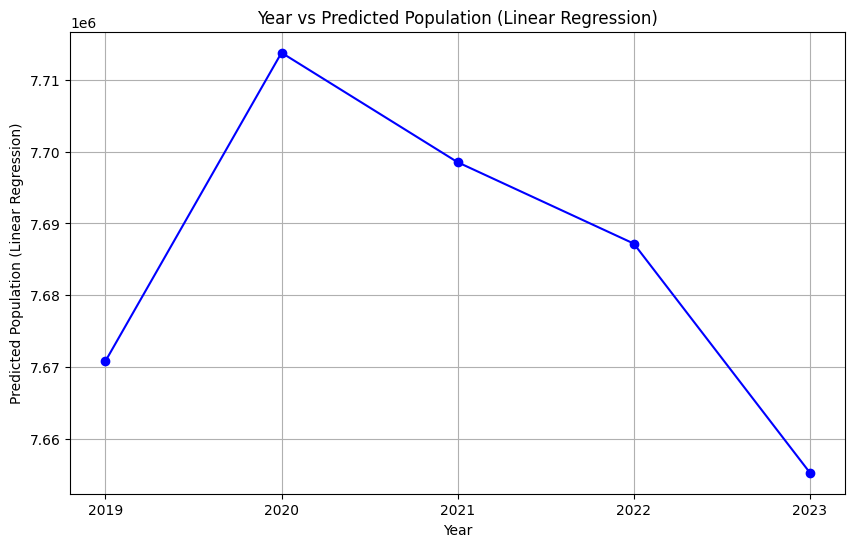

In [30]:
predict_pop_by_crime()